# 安装pakcage

安装

In [1]:
!pip install -i https://mirrors.tencent.com/pypi/simple -U fast-causal-inference

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.tencent.com/pypi/simple

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip


更新

In [ ]:
!pip3 install --upgrade pip -i https://mirrors.tencent.com/pypi/simple -U fast-causal-inference

# 环境设置

#### 配置clickhouse环境

外部用户可以使用如下的clickhouse代理账号，可以连接测试数据库：test，就可以用该数据库下的测试数据集 test_data_small 做分析  

In [2]:
import numpy as np
import pandas as pd

In [3]:

import fast_causal_inference 
import time
import fast_causal_inference.all_in_sql as ais
from fast_causal_inference.all_in_sql import create_sql_instance, clickhouse_create_view,clickhouse_drop_view


# 支持多租户安全隔离，请首先初始化租户信息才可进行后续使用,  可联系bearlyhuang/fhbai/broccozhang获取业务对应的租户信息
# 体验账号
fast_causal_inference.set_tenant(tenant_id='734c699c-f33d-47f7-86be-91a2b2d43362$9f97a6896eac4f059a6240ba3d707dc8', 
secret_key='48c58453351696abab8e47efe42a4cb21f46')
sql_instance = ais.create()


#### 通过spark将tdw数据导到clickhouse里
如果只是想试用，不需要导入自己的数据做分析，可以跳过这一步

GROUP_ID = "xxxx" # todo
GAIA_ID = "xxxx" # todo
ARCHIVES = "hdfs://qy-ieg-4-v2/data/SPARK/cachefile/pythonenv/python3.6.tar.gz#pythonenv"
PYTHON = "./pythonenv/python3.6/bin/python3"
import os
import taiji_ide
os.environ["PYSPARK_PYTHON"] = PYTHON
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars hdfs://qy-ieg-4-v2/data/SPARK/cachefile/all_in_sql/clickhouse-client-0.3.2.jar,hdfs://qy-ieg-4-v2/data/SPARK/cachefile/all_in_sql/clickhouse-http-client-0.3.2.jar,hdfs://qy-ieg-4-v2/data/SPARK/cachefile/all_in_sql/clickhouse-jdbc-0.3.2.jar pyspark-shell'
taiji_ide.set_spark(version="3.1.2", gaia_id=GAIA_ID)
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder.enableHiveSupport()
        .config("spark.yarn.queue", "{}-offline".format(GROUP_ID))
        .config("spark.yarn.dist.archives", ARCHIVES)
        .config("spark.driver.memory", "16g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.blacklist.enabled", "true")
        .config("spark.executor.cores", 4)
        .config("spark.executor.instances", 1000)
        .config("spark.executor.memory", "10g")
        .config("spark.speculation", "false")
        .config("spark.network.timeout","300s")
        .getOrCreate()
)
sc = spark.sparkContext.getOrCreate()
print (sc.uiWebUrl)

# 模型使用示例

### 测试数据集：test_data_small

测试数据表: test_data_small 是793200行的fake data

In [5]:
sql_instance.sql("desc test_data_small;")

[('id', 'UUID', '', '', '', '', ''),
 ('treatment', 'Int64', '', '', '', '', ''),
 ('numerator', 'Float64', '', '', '', '', ''),
 ('denominator', 'Int32', '', '', '', '', ''),
 ('numerator_pre', 'Int64', '', '', '', '', ''),
 ('denominator_pre', 'Int64', '', '', '', '', ''),
 ('y', 'Float64', '', '', '', '', ''),
 ('x1', 'Int64', '', '', '', '', ''),
 ('x2', 'Int64', '', '', '', '', ''),
 ('x3', 'Int32', '', '', '', '', ''),
 ('x3_string', 'String', '', '', '', '', ''),
 ('x7_needcut', 'Int64', '', '', '', '', ''),
 ('x8_needcut', 'Int32', '', '', '', '', ''),
 ('weight', 'Float64', '', '', '', '', ''),
 ('distance', 'Float64', '', '', '', '', ''),
 ('day_', 'Date', '', '', '', '', '')]

In [6]:
columns = np.array(sql_instance.sql("desc test_data_small;"))[:,0]
data = sql_instance.sql("select * from test_data_small limit 5;")
n = sql_instance.sql("select count(*) from test_data_small limit 1;")
print("数据表总样本量：",n)
pd.DataFrame(data,columns=columns)

数据表总样本量： [(793200,)]


,id,treatment,numerator,denominator,numerator_pre,denominator_pre,y,x1,x2,x3,x3_string,x7_needcut,x8_needcut,weight,distance,day_
0,78680536-c4bf-41be-8003-8ee72f0ad9af,1,14.4,1,7,1,7.2,4,1,0,0,0,1,0.930912,3.323649,2023-07-26
1,8d1eb88d-49b6-4005-8005-186110b8fe31,1,360.8,1,11,1,187.4,8,1,0,0,21,716,0.700381,4.803048,2023-07-26
2,b8332177-9563-4158-8005-92ee4276a7d4,1,45.0,1,13,1,22.5,5,2,0,0,1,639,1.410135,6.550677,2023-07-26
3,04c242ac-c6d9-48fc-800b-770ddc99e043,1,14.4,1,7,1,7.2,4,1,0,0,0,17,0.740172,2.560689,2023-07-26
4,4db47836-b1ce-4974-800c-d28e706da32c,1,14.4,1,7,1,7.2,4,1,0,0,0,5,0.898669,3.194677,2023-07-26


### ttest

#### ttest

做双样本t检验，关心的指标是 numerator/denominator，例如点击率指标，numerator代表点击，denominator代表曝光

In [4]:
ttest = sql_instance.sql("""select 
                                ttest_2samp(avg(numerator)/avg(denominator),treatment,'two-sided')
                            from 
                                test_data_small""")
print(ttest)


estimate	stderr		t-statistic	p-value		lower		upper
-179.838780	83.295326	-2.159050	0.030846	-343.095133	-16.582426


#### ttest with CUPED

In [5]:
ttest = sql_instance.sql("""select 
                                ttest_2samp(avg(numerator)/avg(denominator),treatment,'two-sided',
                                    avg(numerator_pre)/avg(denominator_pre)) as ttest_result 
                            from 
                                test_data_small""")
print(ttest)


estimate	stderr		t-statistic	p-value		lower		upper
-180.136134	83.292259	-2.162700	0.030564	-343.386478	-16.885791


#### 维度下钻的ttest

In [29]:
ttest = sql_instance.sql("""select 
                                x2,ttest_2samp(avg(numerator)/avg(denominator),treatment,'two-sided',
                                    avg(numerator_pre)/avg(denominator_pre)) as ttest_result 
                                
                            from 
                                test_data_small
                            group by 
                                x2""")
print(ttest)

[(0, '-508.936880 474.509664  -1.072553   0.283472    -1.439e+03  421.423537'), (1, '39.678734   81.621745   0.486129    0.626875    -120.298005 199.655474'), (2, '-377.804153 142.899413  -2.643847   0.008197    -657.883574 -97.724731')]


### SRM

In [9]:
result = sql_instance.sql("""SELECT  

                                   SRM(x1, treatment, [1,1])
                            FROM  

                                   test_data_small""")
print(result)

[('groupname   f_obs       ratio       chisquare   p-value',), ('0           2.061e+06   1.000000    4989.109656 0.000000',), ('1           2.206e+06   1.000000',)]


### OLS

In [3]:
# ols
result = sql_instance.sql(f"""SELECT

         ols(y~x1+x2)   AS result

FROM

         test_data_small """)
print(result)

Call:
lm(formula = y ~ + x1 + x2)

Coefficients:
		Estimate    Std. Error	t value	    Pr(>|t|)
(Intercept)	524.042837  79.991519   6.55123     0.0         
x1		-1.989127   9.323788    -0.213339   0.831063    
x2		-50.465742  39.735154   -1.270053   0.204066    

Residual standard error: 18276.17839 on 793197 degrees of freedom
Multiple R-squared: 2e-06, Adjusted R-squared: -0.0
F-statistic: 0.834831 on 2 and 793197 DF,  p-value: 0.433948


In [10]:
# predict
#写法1：只适用于在相同数据上做训练和预测
result = sql_instance.sql(f"""SELECT  
            predict(ols(y~x1+x2),x1,x2)  AS result
 FROM
            test_data_small
 limit 10""")
print(result)

[(465.62058580913526,), (457.66407583454975,), (413.1657166888466,), (465.62058580913526,), (465.62058580913526,), (465.62058580913526,), (520.0645824230703,), (461.6423308218425,), (413.1657166888466,), (413.1657166888466,)]


In [11]:
#写法2:适用于在相同或者不同数据集分别做训练和预测
result = sql_instance.sql(f"""WITH (

          SELECT  

                       ols(y~x1+x2)  AS model

          FROM

                    test_data_small

         ) AS model

SELECT
            evalMLMethod (model,x1,x2) AS y_pre

FROM

          test_data_small
limit 10""")
print(result)

[(465.6205858091332,), (457.66407583454793,), (413.16571668884603,), (465.6205858091332,), (465.6205858091332,), (465.6205858091332,), (520.0645824230668,), (461.6423308218406,), (413.16571668884603,), (413.16571668884603,)]


### WLS

In [4]:
result = sql_instance.sql(f"""SELECT

         WLS(y~x1+x2,weight) as result
from test_data_small """)
print(result)

Call:
lm(formula = y ~ + x1 + x2)

Coefficients:
		Estimate    Std. Error	t value	    Pr(>|t|)
(Intercept)	564.991679  79.923956   7.069116    0.0         
x1		-8.834124   8.307573    -1.063382   0.287609    
x2		-74.071379  38.080495   -1.945126   0.05176     

Residual standard error: 14985.332834 on 793197 degrees of freedom
Multiple R-squared: 2.4e-05, Adjusted R-squared: 2.1e-05
F-statistic: 9.456233 on 2 and 793197 DF,  p-value: 7.8e-05


### Lasso

In [12]:
# 训练
ols = sql_instance.sql(f"""SELECT 

stochasticLinearRegression(0.001, 0.1, 15, 'Lasso')(y, x1, x2, x3)

FROM

test_data_small """)
print(ols)

[('[-6.791635533967209,46.67405344838126,1390.877711270237,50.14757670803557]',)]


In [13]:
# 预测
ols = sql_instance.sql(f"""WITH (

          SELECT  

                       stochasticLinearRegressionState(0.001, 0.1, 15, 'Lasso')(y, x1, x2, x3) AS model

          FROM

                    test_data_small

         ) AS model

SELECT
            evalMLMethod(model,x1,x2,x3) AS y_pred

FROM

          test_data_small
limit 10""")
print(ols)

[(265.3983202385086,), (115.53266944864083,), (-96.88367487010237,), (-59.417262172635446,), (15.515563222298411,), (265.3983202385086,), (-59.417262172635446,), (52.98197591976536,), (5565.858709788669,), (-96.88367487010237,)]


### IV

这里的IV方程如下：  
$$Y = X3_{est} + X1 + X2$$
$$X3 = treatment+X1 + X2$$


In [14]:
# iv 
t1=time.time()
iv = sql_instance.sql("""
    SELECT

         ivregression(y~(x3~treatment)+x1+x2)
    FROM
             test_data_small""")
t2=time.time()
print(iv,"用时：",t2-t1)

Call:
lm(formula = y ~ + x1 + x2 + x3)

Coefficients:
		Estimate    Std. Error	t value	    Pr(>|t|)
(Intercept)	-398.910124 83.055245   -4.802949   2e-06       
x1		13360.0     496.325301  26.909273   0.0         
x2		-145.711057 6426.435852 -0.022674   0.981911    
x3		67.0098     64.688061   1.035891    0.300253    

Residual standard error: 18276.134648 on 793196 degrees of freedom
Multiple R-squared: 8e-06, Adjusted R-squared: 4e-06
F-statistic: 2.155517 on 3 and 793196 DF,  p-value: 0.090992 用时： 0.5162167549133301


### matching

In [15]:
# propensitysocre 匹配
data = sql_instance.sql("""SELECT   treatment,weight,caliperMatching(if(treatment=1,-1,1),weight,0.2) AS matchingIndex
FROM
         test_data_small
limit 50
    """)
data

[(0, 0.1, 0),
 (0, 0.11911208942046206, 0),
 (0, 0.20228926737380432, 0),
 (0, 0.21725924702297414, 0),
 (0, 0.35965238764408336, 0),
 (0, 0.49265998927705457, 0),
 (0, 0.4194904442223465, 0),
 (1, 0.6190614633073708, -2.0),
 (1, 0.6916770402322703, 0),
 (1, 0.6901164206653173, 0),
 (1, 0.7695630149146455, 0),
 (1, 0.7296567077817527, 0),
 (1, 0.682981597535075, 0),
 (0, 0.784950404959952, 2),
 (1, 0.9895964300934217, -3.0),
 (1, 0.8784802403250895, 0),
 (1, 0.8036436280942624, 0),
 (1, 0.9265932332320589, 0),
 (1, 0.9921811389485795, 0),
 (1, 0.9918454970446987, 0),
 (1, 0.8048158351575992, 0),
 (0, 0.9822592703817085, 3),
 (1, 1.0391224877767085, -1.0),
 (1, 1.1849022928357364, 0),
 (1, 1.0768818975372432, 0),
 (0, 1.0016238522952479, 1),
 (1, 1.3360388960773217, 0),
 (1, 1.2523023813851883, 0),
 (1, 1.2274193569848826, 0),
 (1, 1.3992599195100508, 0),
 (1, 1.3594367925216064, 0),
 (1, 1.2086202471304268, 0),
 (1, 1.3654435111362124, 0),
 (1, 1.2007851723350549, 0),
 (1, 1.3994199328

In [16]:
# 精确匹配
data = sql_instance.sql("""SELECT  
treatment,x2,exactMatching(if(treatment=1,-1,1),x2) as matchingIndex
FROM  
         test_data_small
limit 20
    """)
data

[(1, 0, 0),
 (1, 1, -3.0),
 (1, 1, 0),
 (1, 1, 0),
 (1, 1, 0),
 (1, 1, 0),
 (1, 1, 0),
 (1, 1, 0),
 (1, 1, 0),
 (1, 1, 0),
 (1, 1, 0),
 (1, 1, 0),
 (1, 1, 0),
 (1, 2, -1.0),
 (1, 2, -2.0),
 (1, 2, 0),
 (1, 2, 0),
 (0, 1, 3),
 (0, 2, 1),
 (0, 2, 2)]

### Uplift模型

#### causal tree

test_data_small_1690351803_new
running, please wait
donetime cost: 0.683094896376133 Seconds
running, please wait
donetime cost: 0.4497803980484605 Seconds


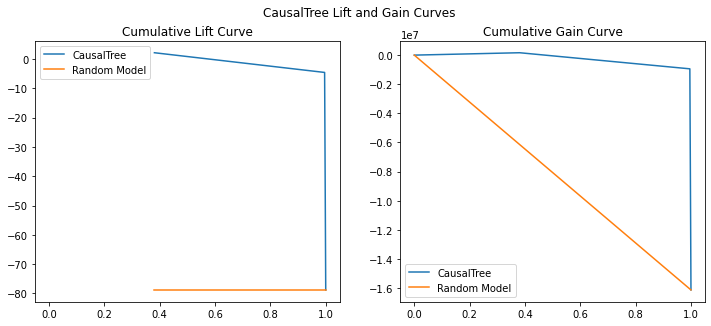

running, please wait
donetime cost: 0.4195002857595682 Seconds
running, please wait
donetime cost: 0.7150361174717546 Seconds
running, please wait
donetime cost: 0.9062180174514651 Seconds
running, please wait
donetime cost: 0.26501098927110434 Seconds


In [18]:
from fast_causal_inference.lib.causaltree import CausalTree
Y='y'
T='treatment'
table = 'test_data_small'
X = 'x1+x2+x3_string+x7_needcut+x8_needcut'
needcut_X = 'x7_needcut+x8_needcut'

hte = CausalTree(depth = 2)
hte.fit(Y,T,X,needcut_X,table)

# 输出树结构的图（可下载）
treeplot = hte.treeplot()
treeplot.render('digraph.gv', view=False) # 可以在digraph.gv.pdf文件里查看tree的完整图片并下载

# 输出训练集上的uplift curve
hte.hte_plot() 
# 输出变量重要性
hte.feature_importance 
clickhouse_drop_view(clickhouse_view_name="test_table_small_causaltree_dep2") 
hte.effect_2_clickhouse(table_output='test_table_small_causaltree_dep2') # 指定一张带预测的表，预测该表的HTE

In [19]:
hte.feature_importance 

,featName,importance
4,x8_needcut_buckets,5.196783e+11
3,x7_needcut_buckets,1.311237e+11
2,x3_string,8.117318e+10
0,x1,3.146347e+10
1,x2,5.023893e+09


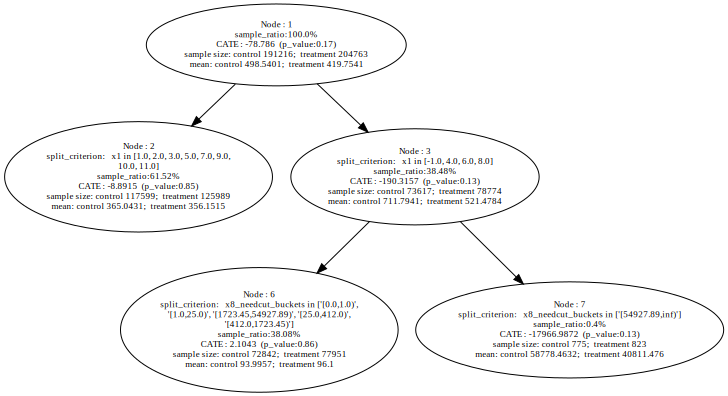

In [20]:
treeplot

### DML

#### LinearDML  

In [21]:
from fast_causal_inference.lib.linear_dml import *


Y='y'
T='treatment'
table = 'test_data_small'
features = ['x1', 'x2']
X_fordml = '+'.join(features)
W='x7_needcut'
model = LinearDML(Y=Y,T=T,X=X_fordml,W=W, model_y="ols", model_t="stochasticLogisticRegression(1.0, 1.0, 10, 'SGD')", cv=2, table=table)


print(model.summary())
print(model.ate('x1+x2',0,1))
print(model.ate_interval('x1+x2',0,1,alpha=0.05))
print(model.effect('x1+x2',0,1))
clickhouse_drop_view(clickhouse_view_name="test_table_output1") 
model.effect('x1+x2',0,1,table_output='test_table_output1') # effect预测结果存到表里
print(model.effect_interval('x2+x3',0,1,0.05))
clickhouse_drop_view(clickhouse_view_name="test_table_output2") 
model.effect_interval('x1+x2',0,1,0.05,table_output='test_table_output2') # effect预测结果存到表里

select linearDML(y,treatment,x1+x2,x7_needcut,model_y=Ols,model_t=stochasticLogisticRegression(1.0, 1.0, 10, 'SGD'),cv=2 ) from test_data_small
		Coefficient Results
		Estimate    Std. Error	t value	    Pr(>|t|)
x0		-16.527335  12.923965   -1.278813   0.200963    
x1		-93.961365  55.079687   -1.705917   0.088024    

		CATE Intercept Results
		Estimate    Std. Error	t value	    Pr(>|t|)
cate_intercept	198.872537  111.059332  1.790687    0.073344    

[(-74.13067596989015,)]
mean_point	ci_mean_lower	ci_mean_upper	
-11.5109622004	-68.9142594444	45.8923350435	
[(-5.025340926114438,), (-112.0039323788634,), (-40.3502194986562,), (-5.025340926114438,), (65.62441621896909,), (-181.6497337888233,), (-41.35417523377981,), (-76.67905380632158,), (-41.35417523377981,), (206.9239305091362,), (-41.35417523377981,), (-5.025340926114438,), (30.299537646427325,), (-110.99997664373979,), (29.295581911303742,), (-41.35417523377981,), (-182.65368952394692,), (-182.65368952394692,), (100.94929479151088,)

#### LinearDML (T进行treatment_featurizer)

In [22]:
Y='y'
T='treatment'
table = 'test_data_small'
features = ['x1', 'x2']
X_fordml = '+'.join(features)
W='x7_needcut'
model = LinearDML(Y=Y,T=T,X=X_fordml,W=W, model_y="ols", model_t="ols", cv=2, table=table, treatment_featurizer=PolynomialFeatures('rand()', 3))
print('\n----summary----')
print(model.summary())
print(model.effect(T0=0.1, T1=0.2))
print(model.const_marginal_effect())
print(model.marginal_effect())
print(model.marginal_ate())

select linearDML(y,treatment,x1+x2,x7_needcut,model_y=Ols,model_t=Ols,cv=2,treatment_featurizer=pow(rand(),1)+pow(rand(),2)+pow(rand(),3) ) from test_data_small

----summary----
		Coefficient Results
		Estimate    Std. Error	t value	    Pr(>|t|)
x0		0.0         0.0         0.167104    0.867288    
x1		-0.0        0.0         -0.029003   0.976862    
x2		-0.0        0.0         -0.06871    0.94522     
x3		0.0         0.0         1.698255    0.08946     
x4		-0.0        0.0         -1.636151   0.101808    
x5		0.0         0.0         1.501046    0.133344    
x6		-0.0        0.0         -1.492199   0.135647    
x7		0.0         0.0         1.417361    0.156378    

		CATE Intercept Results
		Estimate    Std. Error	t value	    Pr(>|t|)
cate_intercept	-0.0        0.0         -1.286949   0.198112    

[('-5.480888269968935e-9',), ('-6.372931544420077e-9',), ('-8.14129668199954e-9',), ('-5.480888269968935e-9',), ('-1.6007144590772722e-10',), ('-1.878293033012194e-8',), ('-1.0521147203588687e-

#### NonparamDML

In [23]:

from fast_causal_inference.lib.linear_dml import NonParamDML

Y='y'
T='treatment'
table = 'test_data_small'
features = ['x1', 'x2']
X_fordml = '+'.join(features)
W='x7_needcut'

model = NonParamDML(table=table, Y=Y,T=T,X=X_fordml, model_y='Ols', model_t='Ols', cv=2)
print('\n----summary----')
print(model.summary())


----summary----
		Coefficient Results
		Estimate    Std. Error	t value	    Pr(>|t|)
x0		-30.48435   18.713887   -1.628969   0.10332     
x1		-182.901006 79.747432   -2.293503   0.021819    

		CATE Intercept Results
		Estimate    Std. Error	t value	    Pr(>|t|)
cate_intercept	345.938966  160.553836  2.15466     0.031189    



### Uplift模型评估

这里是对比了用causaltree 不同深度的模型，在预测集上的uplift curve

    ratio          lift        gain        ate  ramdom_gain
0    0.01 -13298.019217 -132.980192 -89.937528    -0.899375
1    0.02  -9545.674994 -190.913500 -89.937528    -1.798751
2    0.03  -1113.252833  -33.397585 -89.937528    -2.698126
3    0.04    -84.997220   -3.399889 -89.937528    -3.597501
4    0.05    220.251901   11.012595 -89.937528    -4.496876
..    ...           ...         ...        ...          ...
95   0.96     -6.824571   -6.551589 -89.937528   -86.340027
96   0.97     -3.347612   -3.247183 -89.937528   -87.239403
97   0.98     -2.181735   -2.138100 -89.937528   -88.138778
98   0.99     -5.886501   -5.827636 -89.937528   -89.038153
99   1.00    -89.937528  -89.937528 -89.937528   -89.937528

[100 rows x 5 columns]
    ratio         lift       gain        ate  ramdom_gain
0    0.01 -1511.789203 -15.117892 -89.937528    -0.899375
1    0.02   -74.741240  -1.494825 -89.937528    -1.798751
2    0.03    69.608643   2.088259 -89.937528    -2.698126
3    0.04   122.027516  

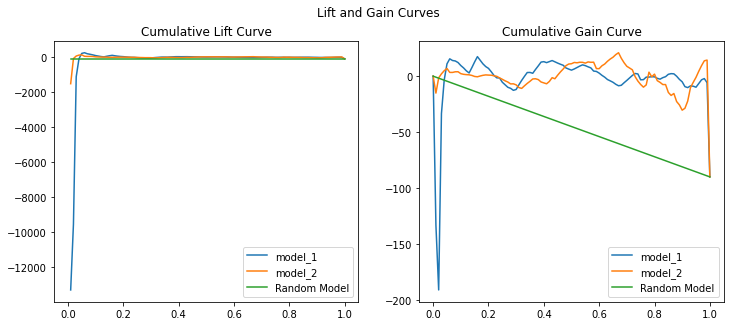

In [24]:
from fast_causal_inference.lib.metrics import *
tmp1 = get_lift_gain("effect", "y", "treatment", "test_table_small_causaltree_dep3",discrete_treatment=False, K=100)
tmp1.summary()
tmp2 = get_lift_gain("effect", "y", "treatment", "test_table_small_causaltree_dep2",discrete_treatment=False, K=100)
tmp2.summary()
hte_plot([tmp1, tmp2])